In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [4]:
import display
import dataloader
from dataloader import ThermalData
import clustering
import anomaly_detection

画像データの取得

In [5]:
thermal_img_files = dataloader.get_img_files(dir_path="./images/modules",gray=False)
thermal_img_files_gray = dataloader.get_img_files(dir_path="./images/modules",gray=True)

In [6]:
type(thermal_img_files), len(thermal_img_files)

(dict, 158)

温度データの取得

In [7]:
data = ThermalData(thermal_img_files)

温度分布の確認（個別）

温度分布の確認

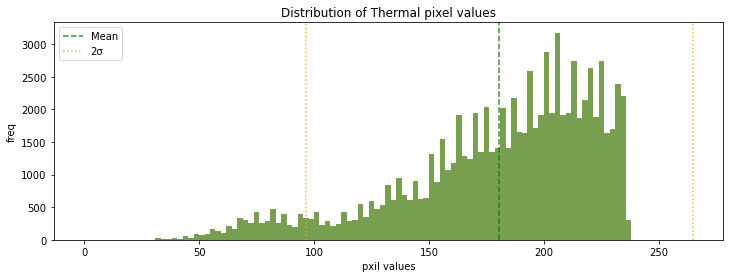

In [8]:
display.display_distributions(data.all_temperature, 
                              filepath = "hist_all_temperature.jpg")

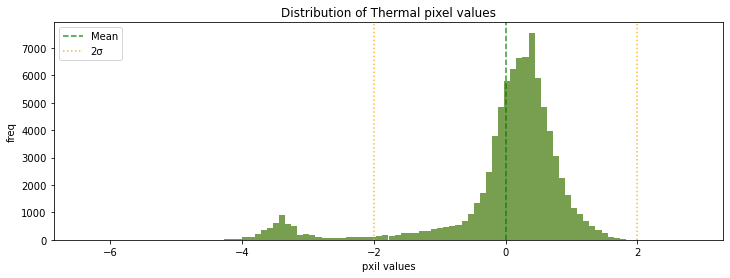

In [9]:
display.display_distributions(data.scaled_all_temperature,
                              filepath = "hist_scaled_all_temperature.jpg")

クラスタ分類モデルの作成

In [10]:
gmm1 = anomaly_detection.AnoGMM(data.all_temperature)
gmm2 = anomaly_detection.AnoGMM(data.scaled_all_temperature)

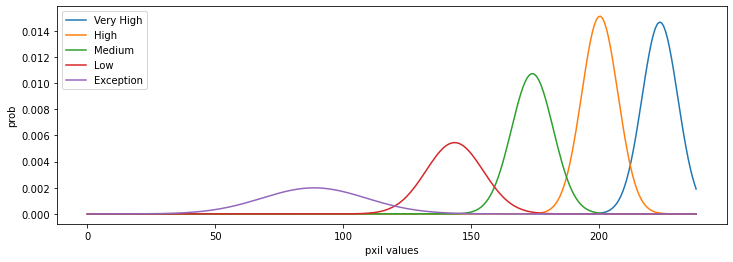

In [11]:
gmm1.display()

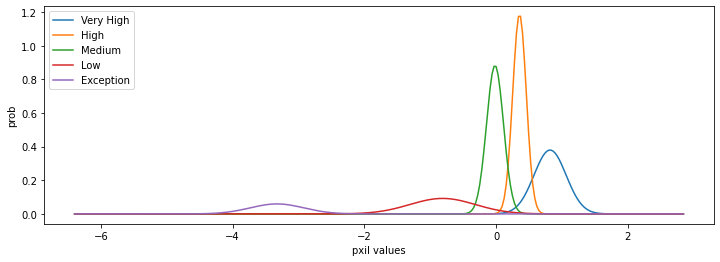

In [12]:
gmm2.display()

個別画像の分析

In [13]:
#input_file = "72.jpg"
#input_file = "12.jpg"
#input_file = "126.jpg"
#input_file = "130.jpg"
input_file = "176.jpg"

ピクセルのクラスタリング（by 温度＆位置）

In [50]:
#clustering_method="kmeans"
#clustering_method="xmeans" # not stable
clustering_method="dbscan"

In [51]:
clusters = clustering.TemperatureClusters(
    data.scaled_temperature_with_index[input_file], method=clustering_method)

In [52]:
clusters_temperature = clusters.get_clusters_data(data.temperature[input_file])
centers_temperature = np.stack([np.uint8(t.mean(axis=0)) for t in clusters_temperature])

In [53]:
scaled_clusters_temperature = clusters.get_clusters_data(data.scaled_temperature[input_file])
scaled_centers_temperature = np.stack([t.mean(axis=0) for t in scaled_clusters_temperature ])

クラスタリング結果の表示

In [54]:
img_clustered = centers_temperature[clusters.labels]
img_clustered = img_clustered.reshape(thermal_img_files[input_file].shape)

In [55]:
import matplotlib.cm as cm
from sklearn import preprocessing
mscaler = preprocessing.MinMaxScaler()
colors = cm.viridis(clusters.labels)[:, :3]
img_colored = np.uint8(mscaler.fit_transform(colors) * 255)
img_colored = img_colored.reshape(thermal_img_files[input_file].shape)
img_colored  = cv2.cvtColor(img_colored, cv2.COLOR_BGR2GRAY)

In [56]:
mask = data.scaled_temperature[input_file] > -2
mask = mask.reshape(thermal_img_files[input_file].shape)

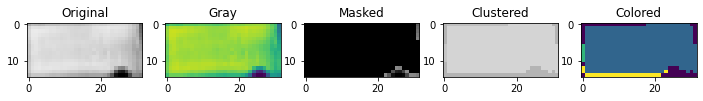

In [57]:
display.display_modules({
    "Original": thermal_img_files[input_file], 
    "Gray": thermal_img_files_gray[input_file],
    "Masked": (thermal_img_files[input_file]*~mask),
    "Clustered": img_clustered,
    "Colored": img_colored,
})

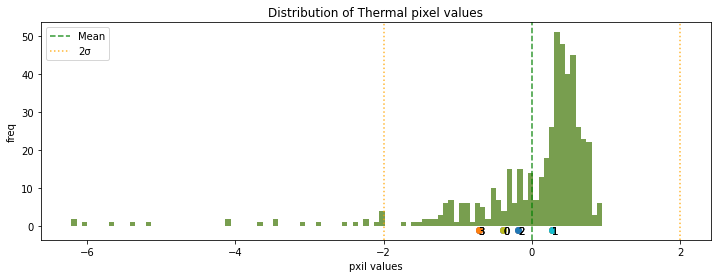

In [60]:
display.display_distributions(data.scaled_temperature[input_file], 
                              filepath = "test.jpg", cluster_centers = scaled_centers_temperature)

クラスタの分類&異常タイプの特定

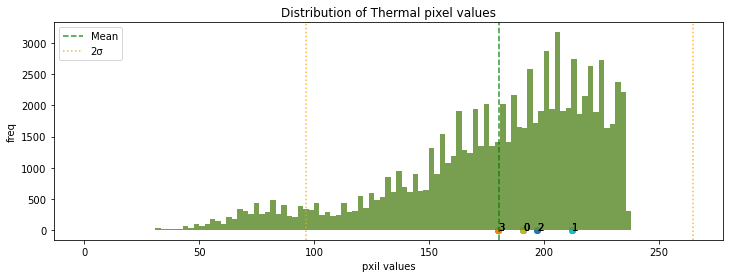

In [61]:
display.display_distributions(data.all_temperature, 
                              filepath = "test.jpg", cluster_centers = centers_temperature)

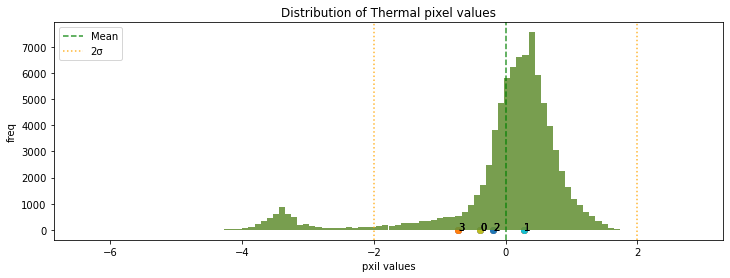

In [62]:
display.display_distributions(data.scaled_all_temperature, 
                              filepath = "test.jpg", cluster_centers = scaled_centers_temperature)

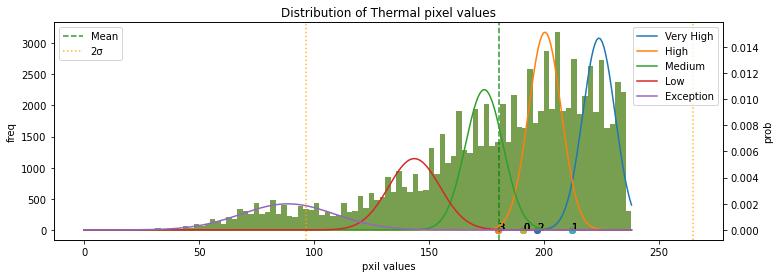

In [63]:
display.display_distributions(data.all_temperature, 
                              filepath = "test.jpg", cluster_centers = centers_temperature, gmm=gmm1)

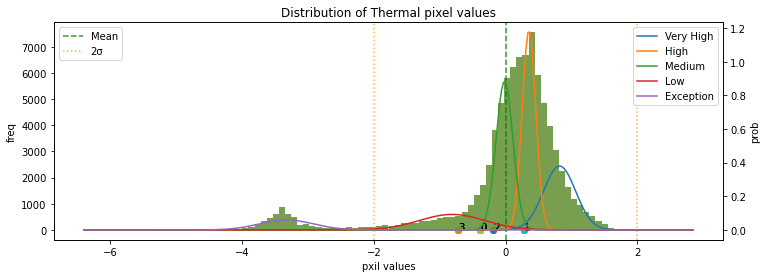

In [64]:
display.display_distributions(data.scaled_all_temperature, 
                              filepath = "test.jpg", cluster_centers = scaled_centers_temperature, gmm=gmm2)

In [65]:
def get_module_anomaly_type(temperature, gmm, img_file, log=False):
    # -- hot cluster --
    predicted_classes = gmm.predict(temperature)
    cluster_types = np.array([gmm.index2class[c] for c in predicted_classes ])
    hot_clusters = (cluster_types == "Very High")
    # -- hot pixcel --
    hot_pixels = np.array([ gmm.index2class[c] =="Very High" for c in predicted_classes[clusters.labels] ])
    hot_pixels = hot_pixels.reshape(*img_file.shape[:2],1)  
    # -- module type --
    module_type = anomaly_detection.detect_module_type(hot_clusters, hot_pixels)
    if log:
        print("Module type:", module_type)
        print("Cluster types:",cluster_types)
        print("Hotspot weights:",hot_pixels.mean())
    return module_type, hot_pixels, cluster_types

In [66]:
module_type1, hot_pixels1, cluster_types1 = get_module_anomaly_type(
    centers_temperature, gmm1, thermal_img_files[input_file], log=True)

Module type: Normal
Cluster types: ['High' 'High' 'High' 'Medium']
Hotspot weights: 0.0


In [67]:
module_type2, hot_pixels2, cluster_types2 = get_module_anomaly_type(
    scaled_centers_temperature, gmm2, thermal_img_files[input_file], log=True)

Module type: Normal
Cluster types: ['Low' 'High' 'Medium' 'Low']
Hotspot weights: 0.0


異常タイプの確認テスト

In [71]:
anomaly_modules= {}
#clustering_method="kmeans"
#clustering_method="xmeans" # not stable
clustering_method="dbscan"

******* start *******
63.jpg
Module type1: Normal
Module type2: Normal


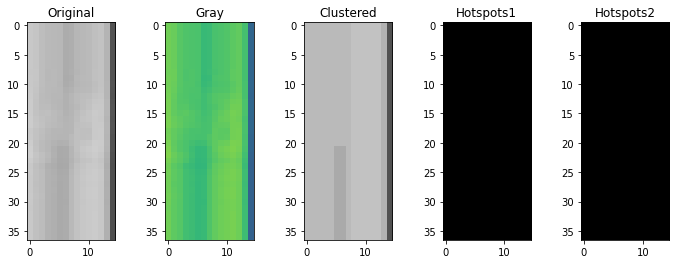

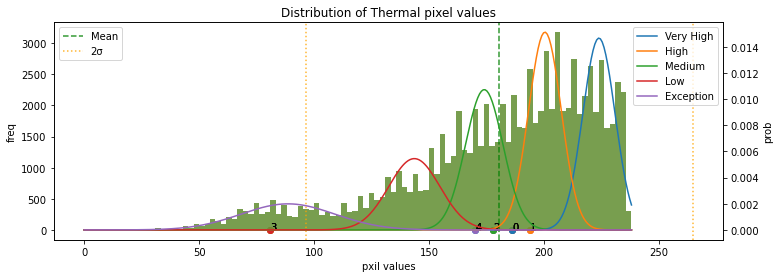

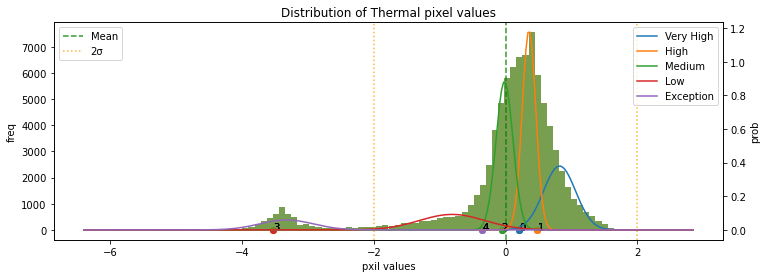

******* end *******
******* start *******
189.jpg
Module type1: Module-Anomaly
Module type2: Normal


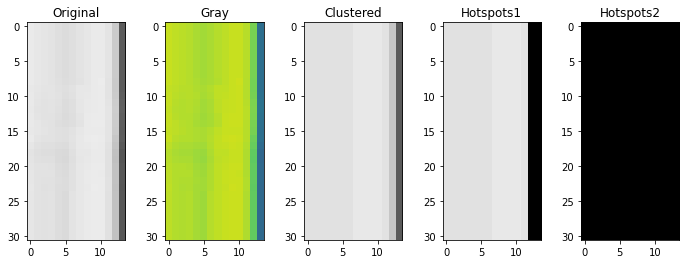

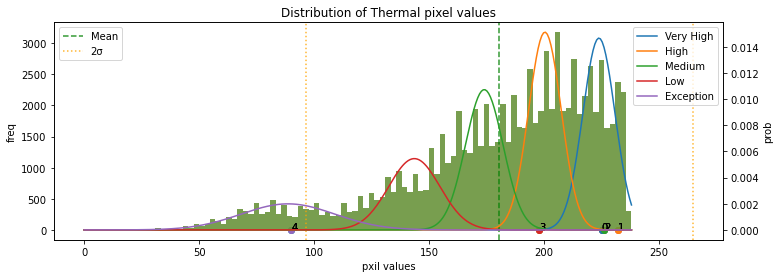

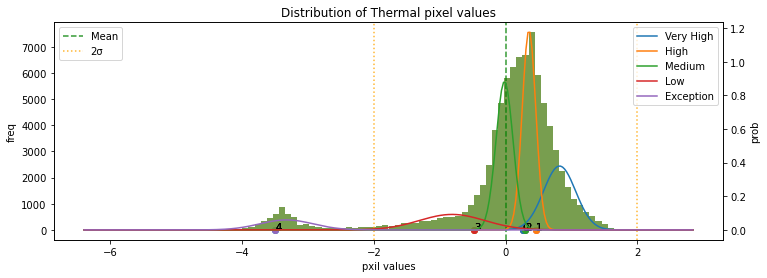

******* end *******
******* start *******
77.jpg
Module type1: Normal
Module type2: Multi-Hotspots


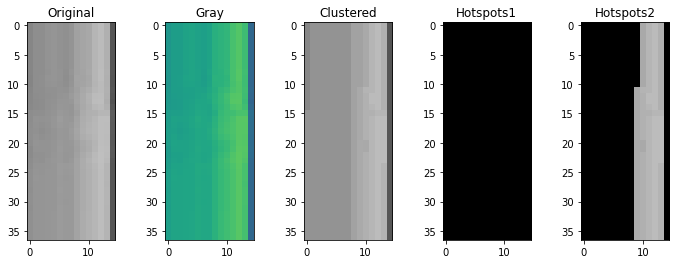

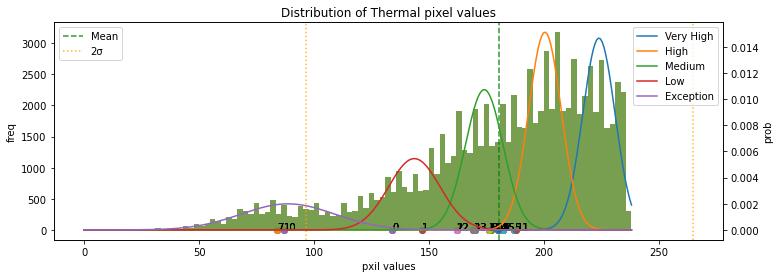

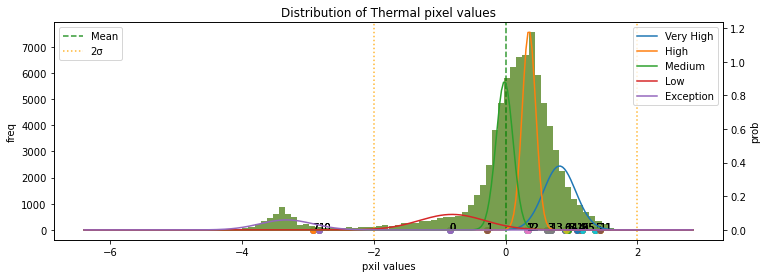

******* end *******
******* start *******
162.jpg
Module type1: Single-Hotspot
Module type2: Multi-Hotspots


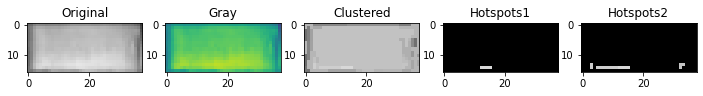

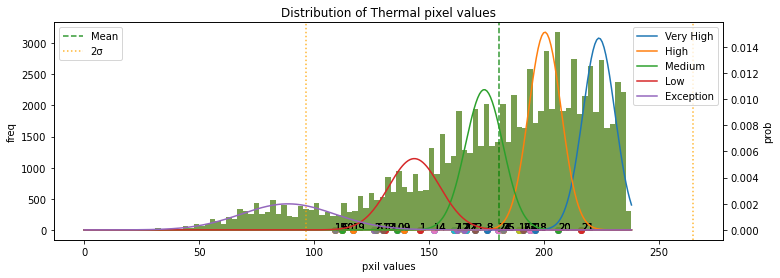

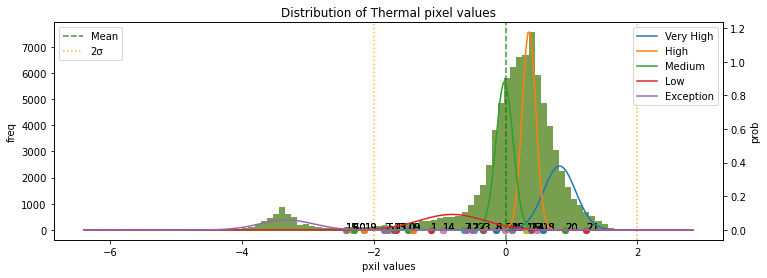

******* end *******
******* start *******
176.jpg
Module type1: Multi-Hotspots
Module type2: Normal


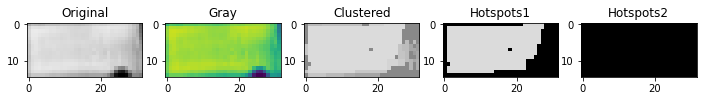

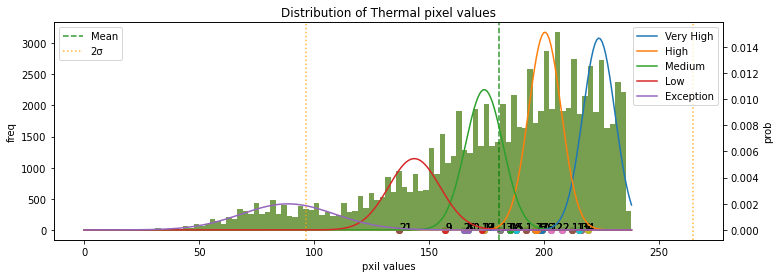

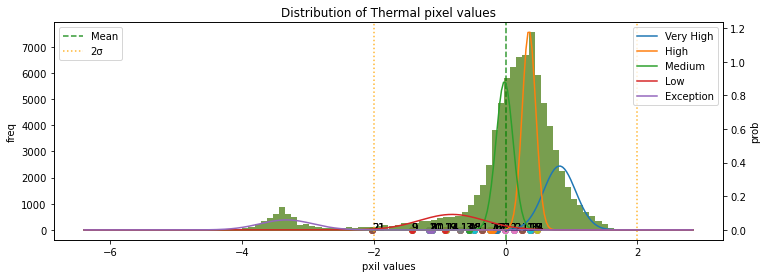

******* end *******
******* start *******
88.jpg
Module type1: Normal
Module type2: Single-Hotspot


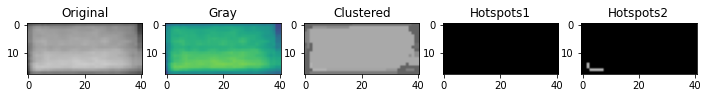

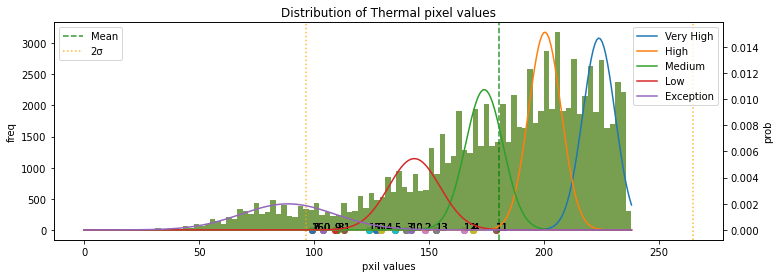

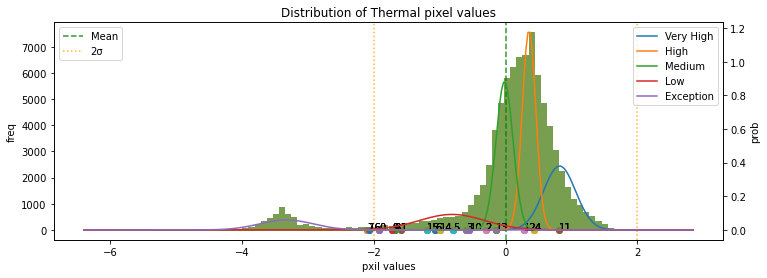

******* end *******
******* start *******
200.jpg
Module type1: Module-Anomaly
Module type2: Normal


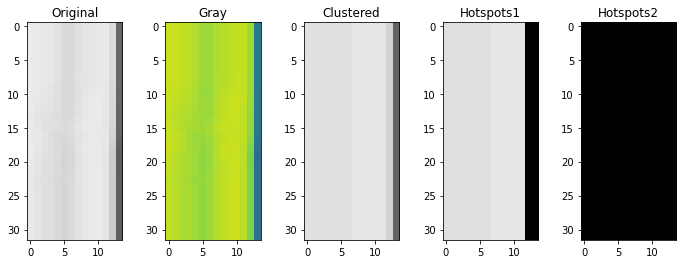

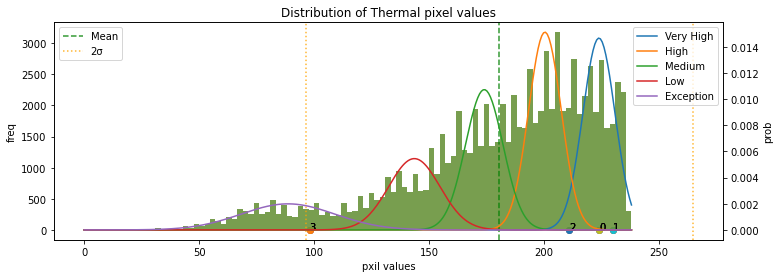

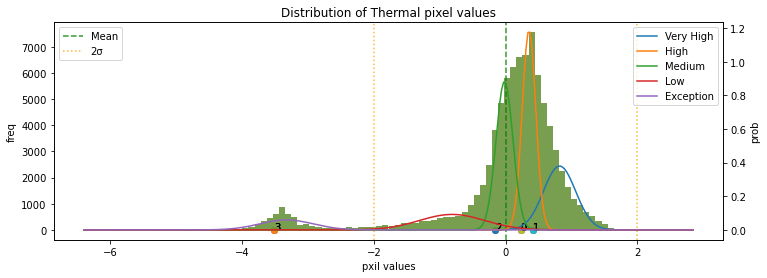

******* end *******
******* start *******
201.jpg
Module type1: Module-Anomaly
Module type2: Normal


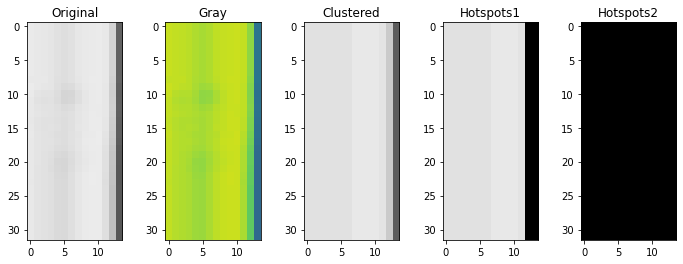

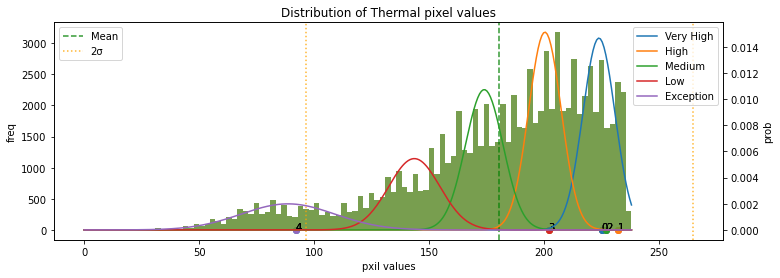

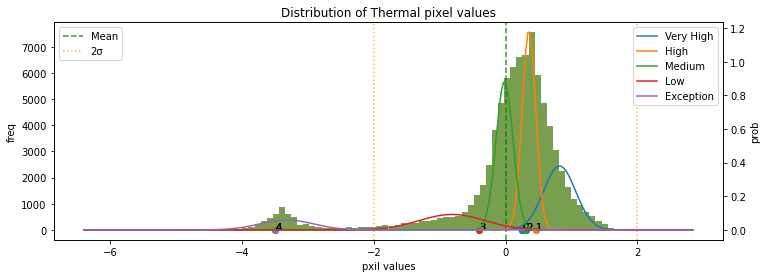

******* end *******
******* start *******
188.jpg
Module type1: Cluster-Anomaly
Module type2: Single-Hotspot


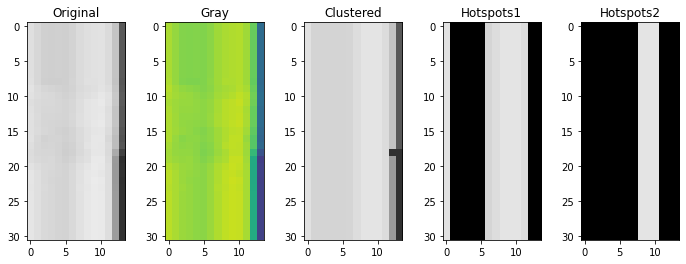

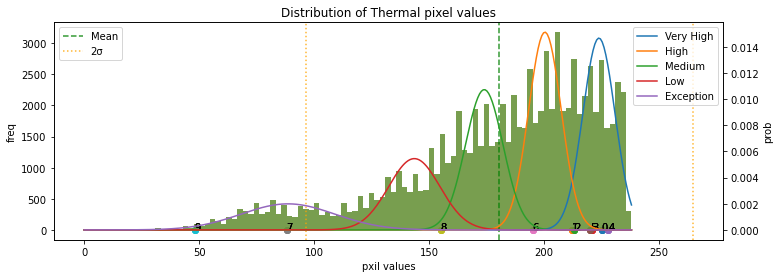

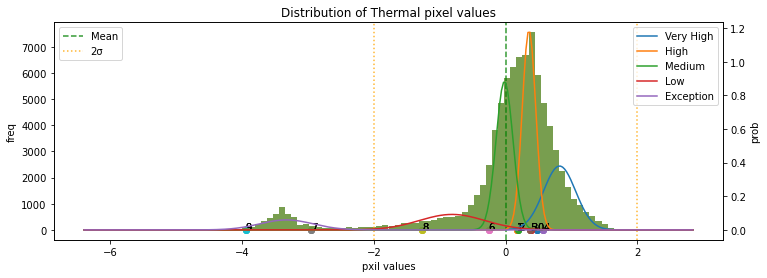

******* end *******
******* start *******
76.jpg
Module type1: Normal
Module type2: Multi-Hotspots


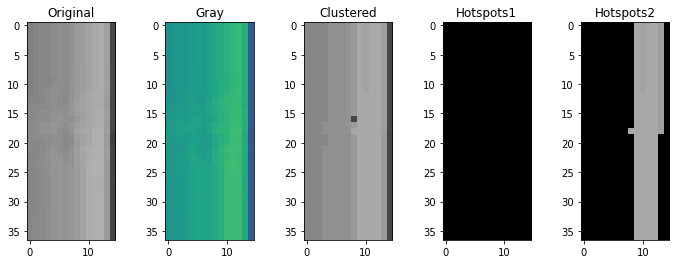

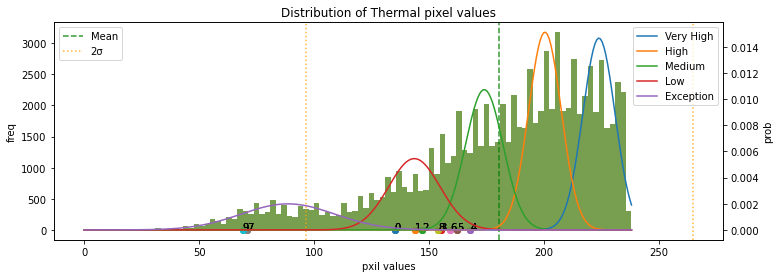

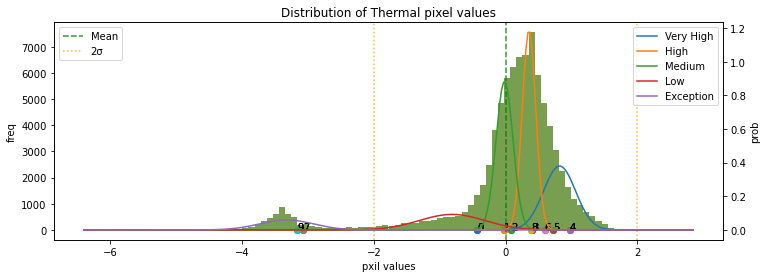

******* end *******
******* start *******
62.jpg
Module type1: Normal
Module type2: Multi-Hotspots


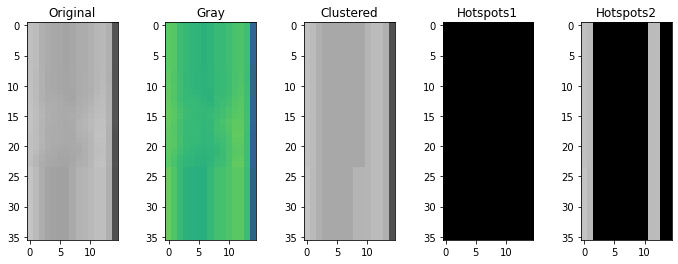

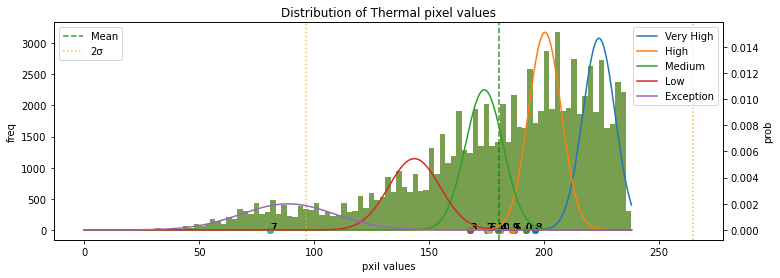

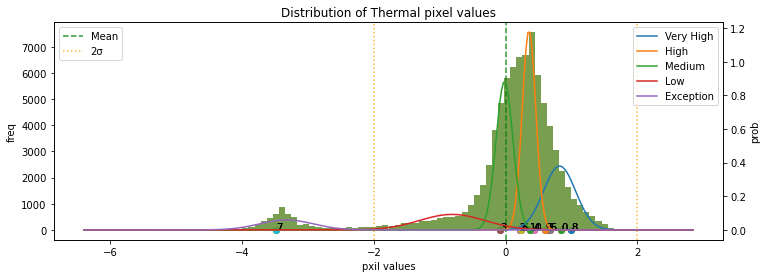

******* end *******
******* start *******
74.jpg
Module type1: Normal
Module type2: Multi-Hotspots


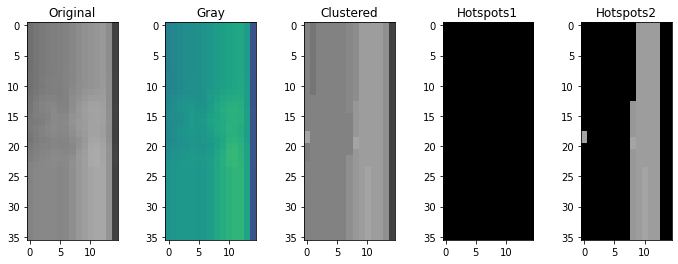

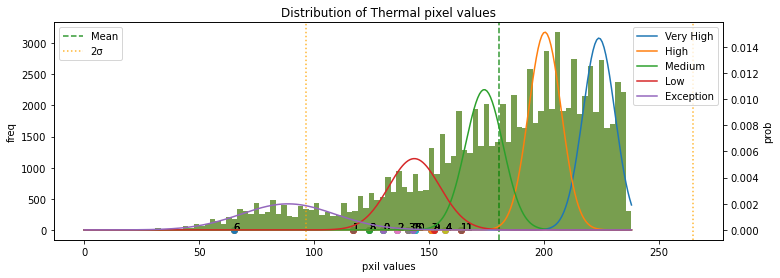

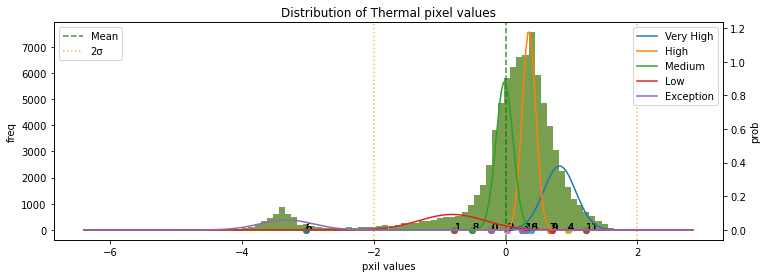

******* end *******
******* start *******
60.jpg
Module type1: Normal
Module type2: Multi-Hotspots


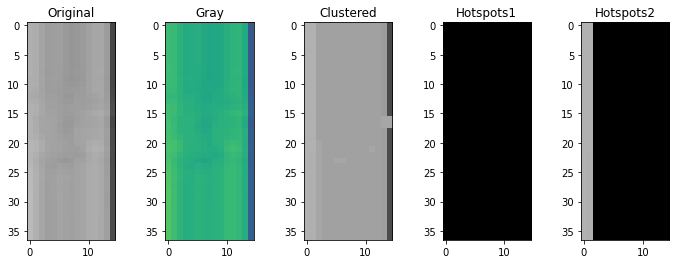

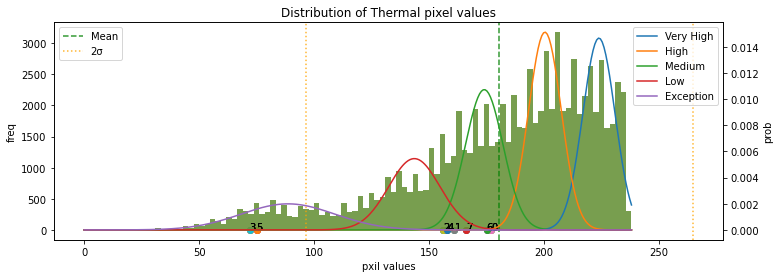

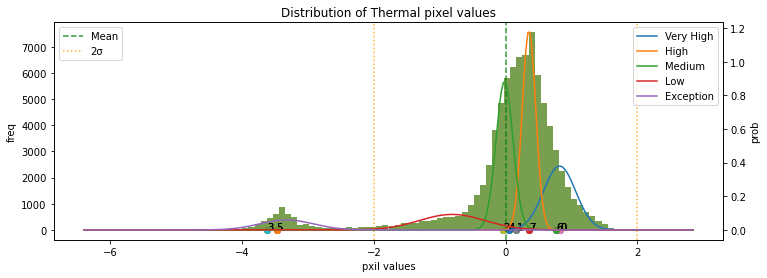

******* end *******
******* start *******
48.jpg
Module type1: Normal
Module type2: Single-Hotspot


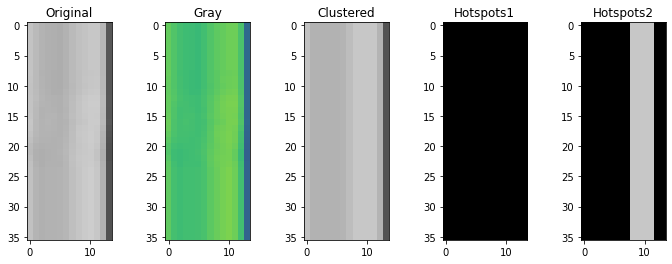

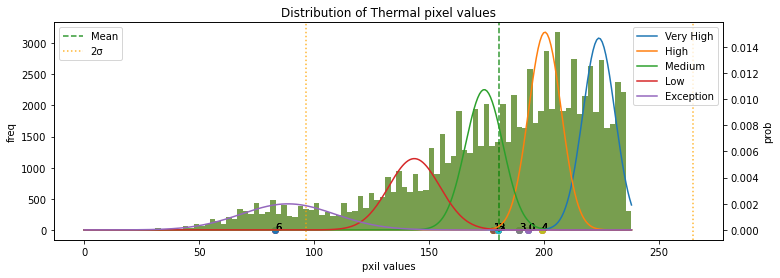

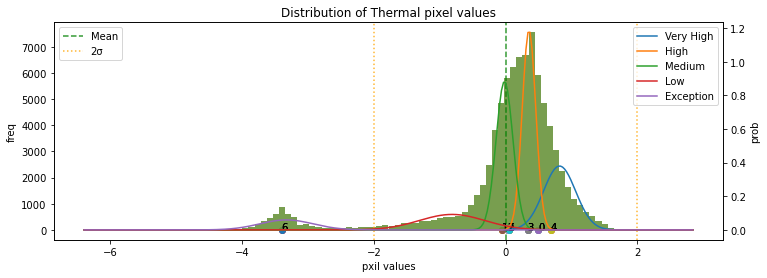

******* end *******
******* start *******
149.jpg
Module type1: Cluster-Anomaly
Module type2: Single-Hotspot


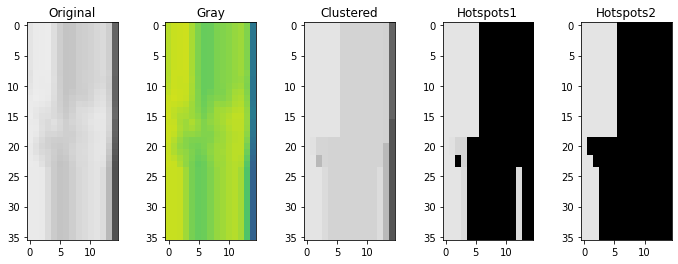

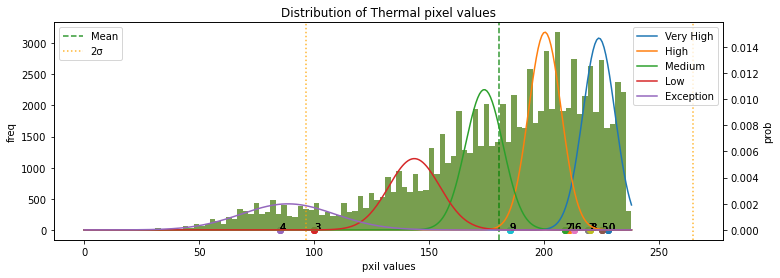

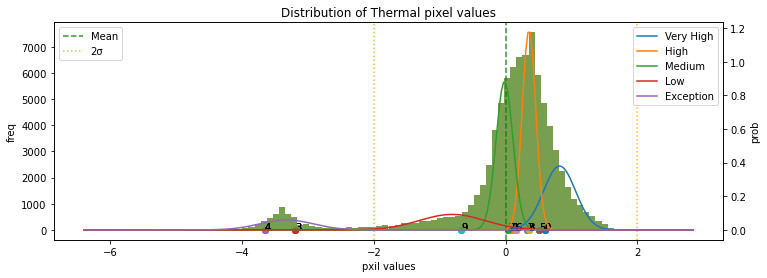

******* end *******
******* start *******
175.jpg
Module type1: Multi-Hotspots
Module type2: Multi-Hotspots


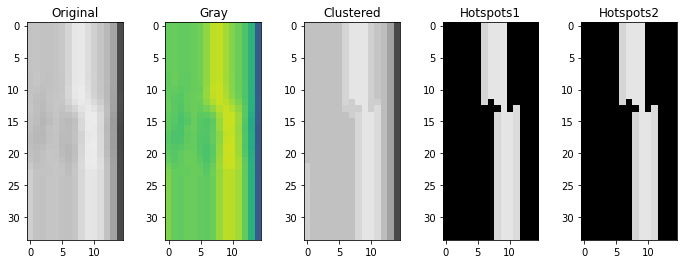

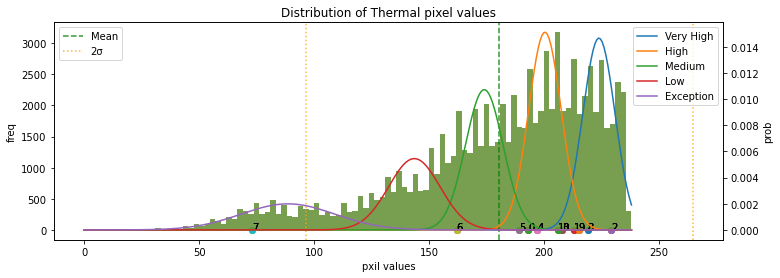

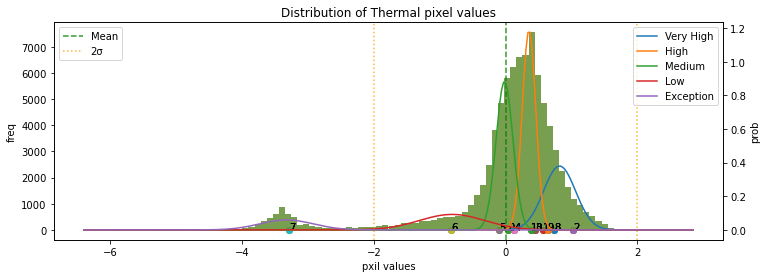

******* end *******
******* start *******
161.jpg
Module type1: Single-Hotspot
Module type2: Multi-Hotspots


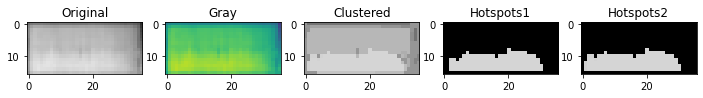

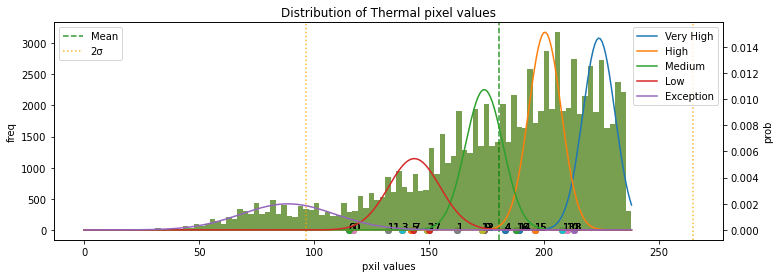

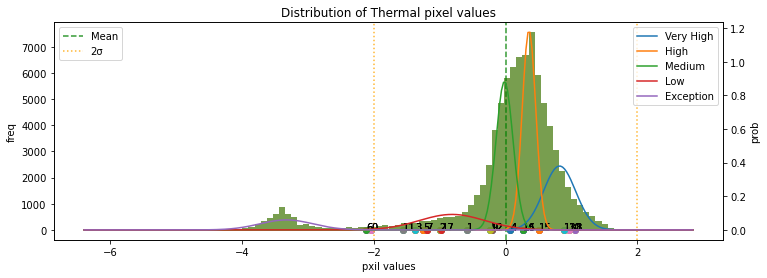

******* end *******
******* start *******
203.jpg
Module type1: Module-Anomaly
Module type2: Normal


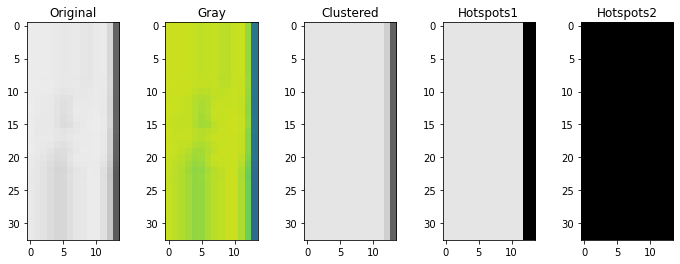

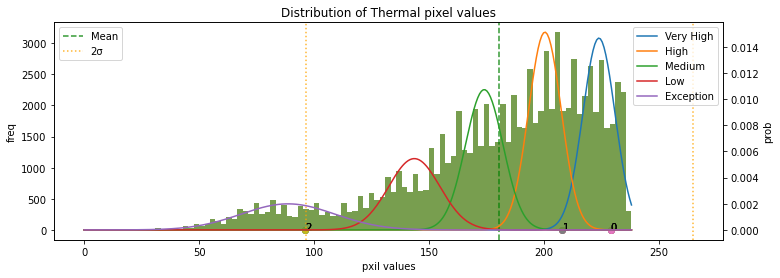

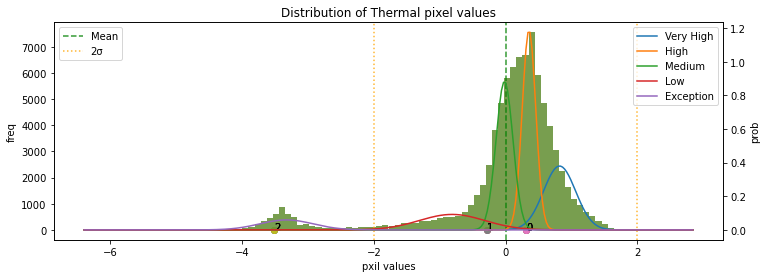

******* end *******
******* start *******
202.jpg
Module type1: Module-Anomaly
Module type2: Normal


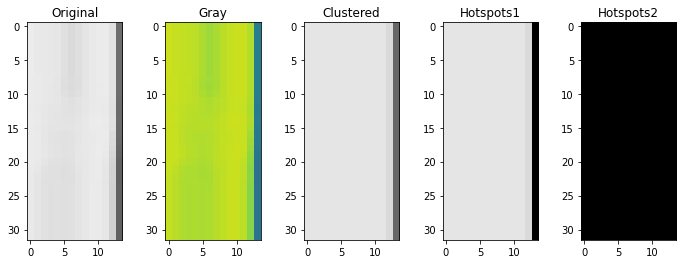

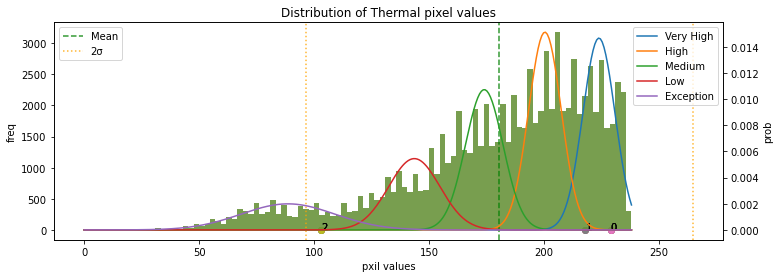

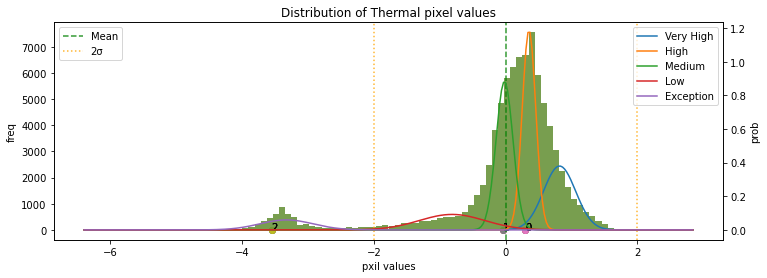

******* end *******
******* start *******
160.jpg
Module type1: Single-Hotspot
Module type2: Cluster-Anomaly


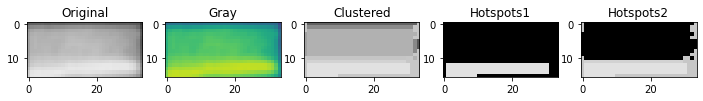

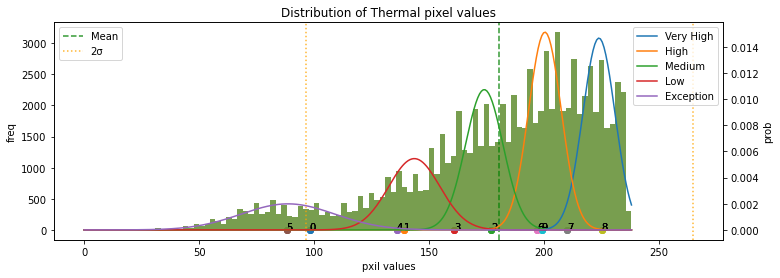

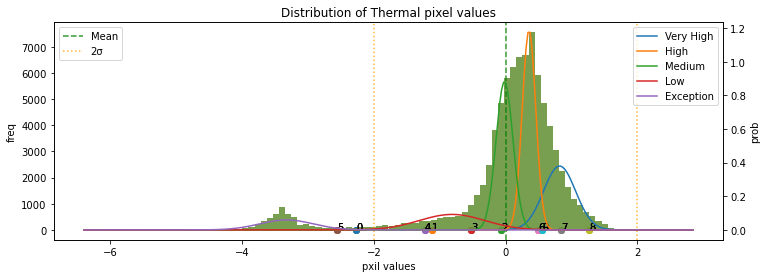

******* end *******
******* start *******
148.jpg
Module type1: Cluster-Anomaly
Module type2: Single-Hotspot


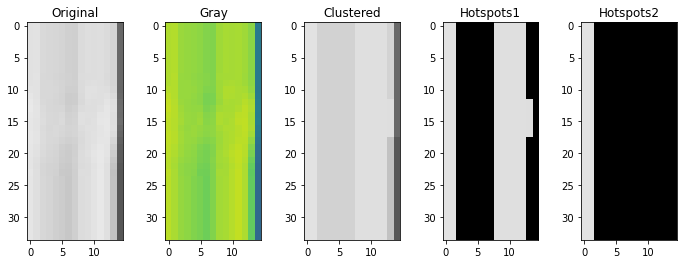

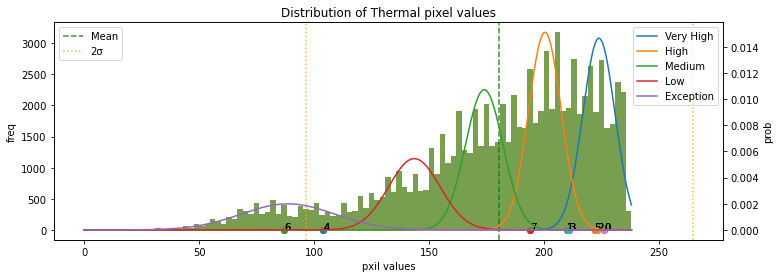

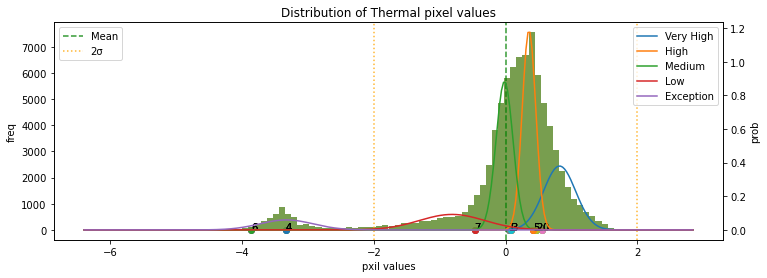

******* end *******
******* start *******
49.jpg
Module type1: Multi-Hotspots
Module type2: Cluster-Anomaly


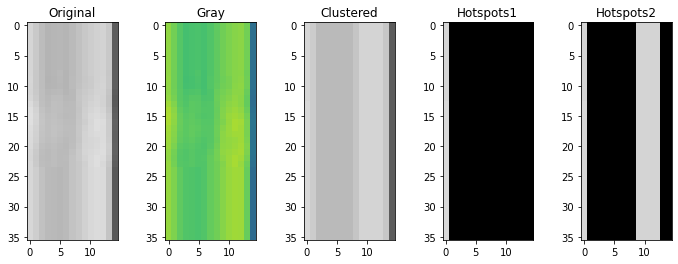

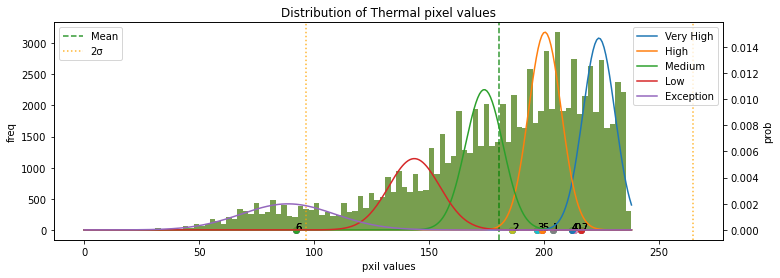

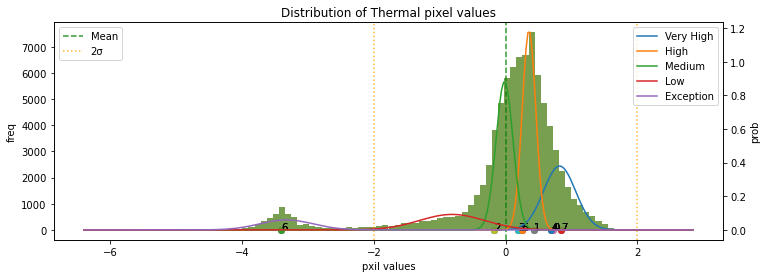

******* end *******
******* start *******
61.jpg
Module type1: Normal
Module type2: Multi-Hotspots


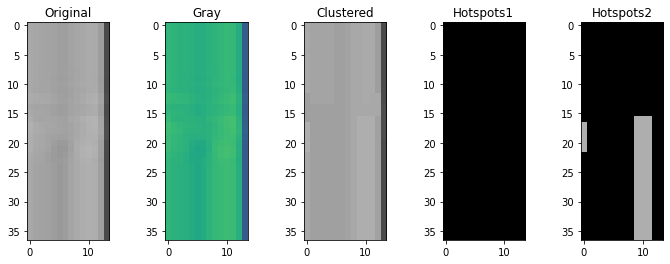

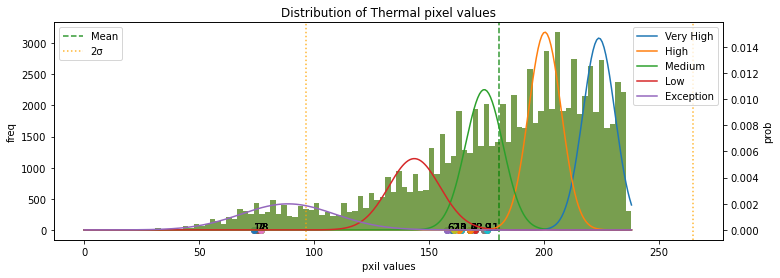

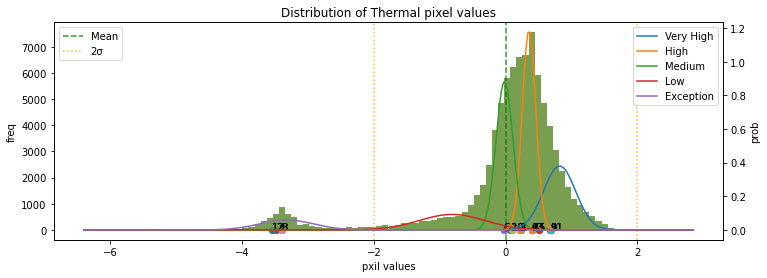

******* end *******
******* start *******
75.jpg
Module type1: Normal
Module type2: Multi-Hotspots


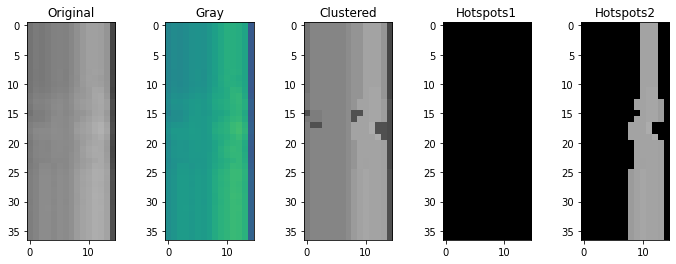

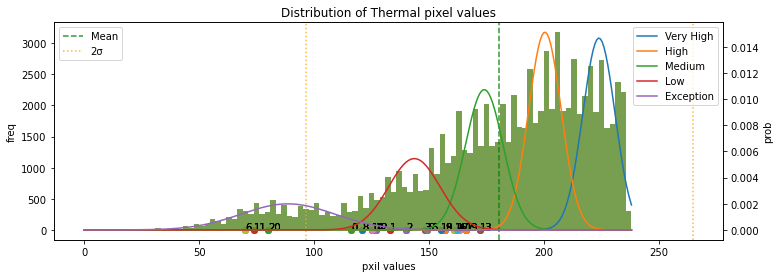

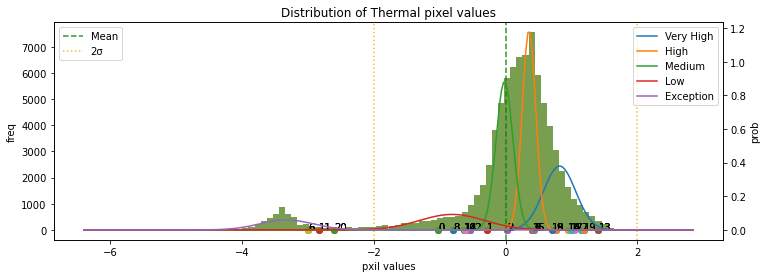

******* end *******
******* start *******
59.jpg
Module type1: Single-Hotspot
Module type2: Cluster-Anomaly


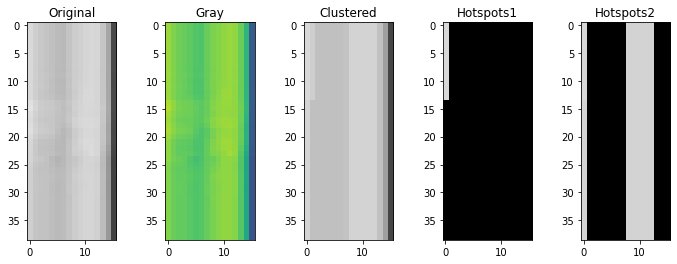

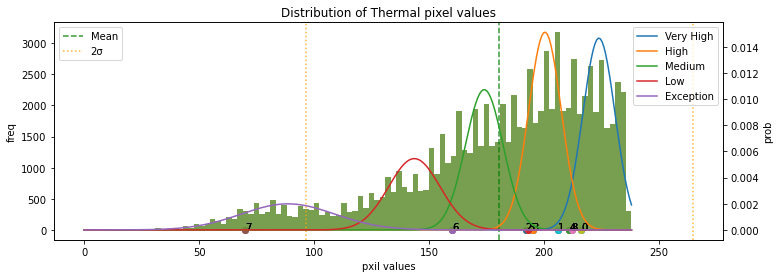

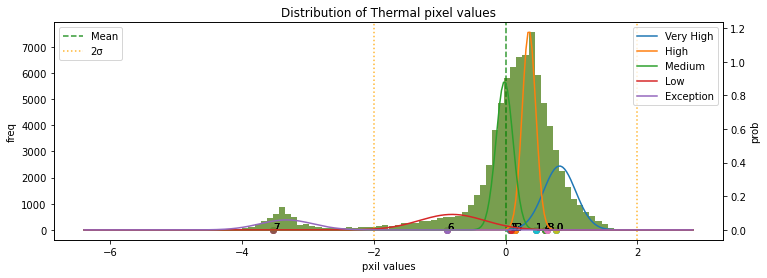

******* end *******
******* start *******
71.jpg
Module type1: Multi-Hotspots
Module type2: Multi-Hotspots


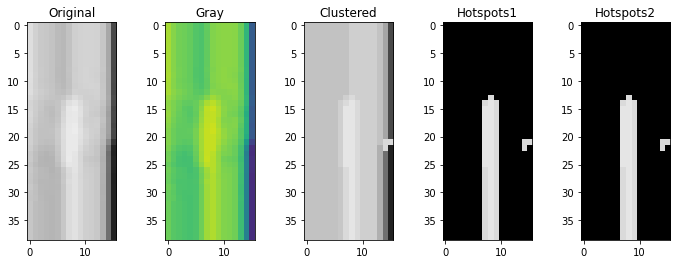

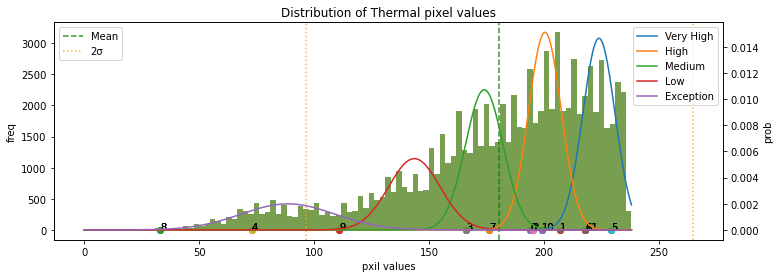

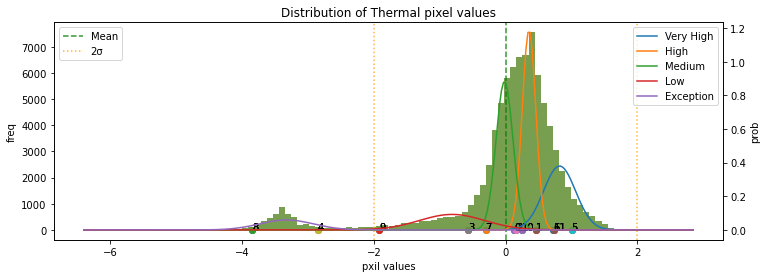

******* end *******
******* start *******
65.jpg
Module type1: Normal
Module type2: Cluster-Anomaly


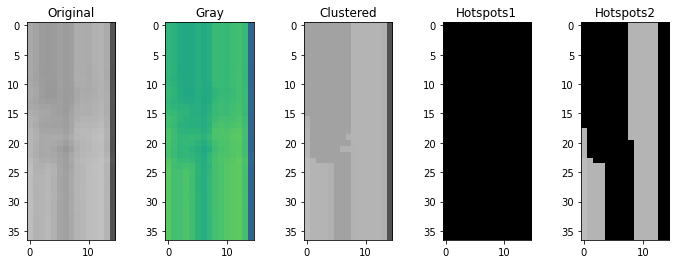

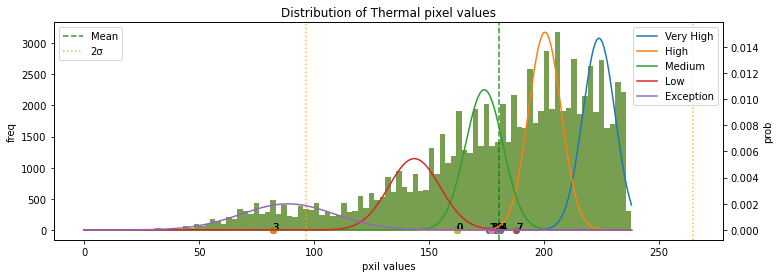

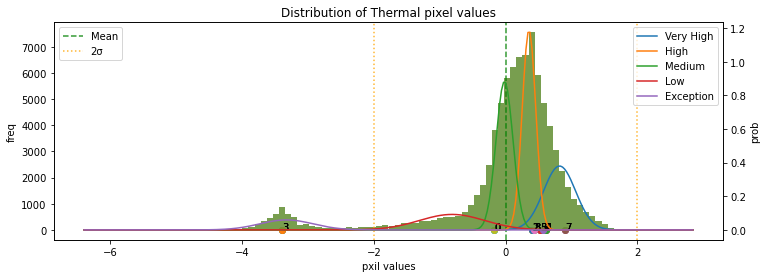

******* end *******
******* start *******
158.jpg
Module type1: Normal
Module type2: Multi-Hotspots


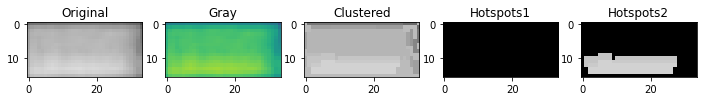

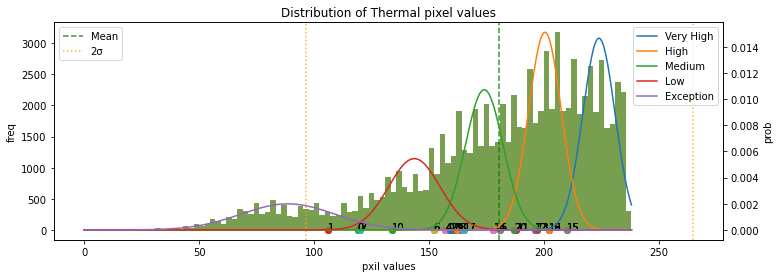

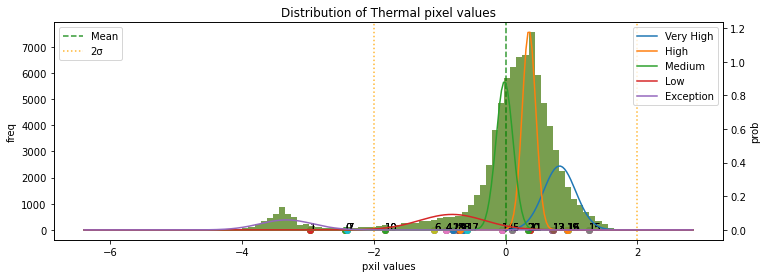

******* end *******
******* start *******
206.jpg
Module type1: Normal
Module type2: Multi-Hotspots


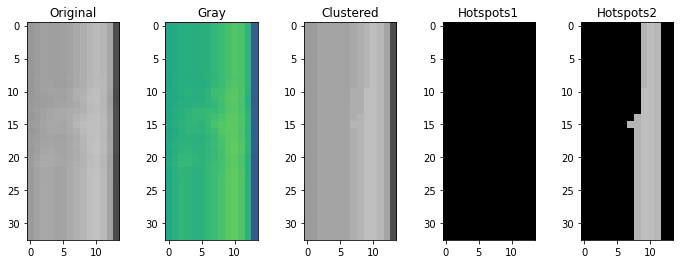

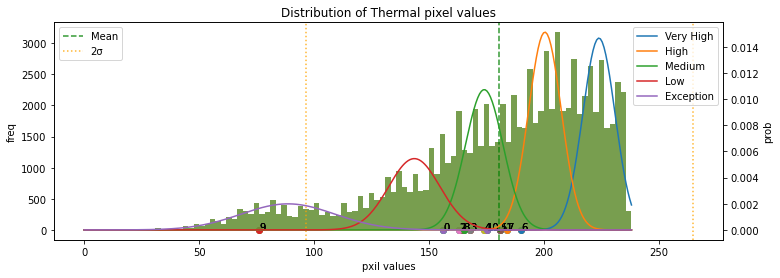

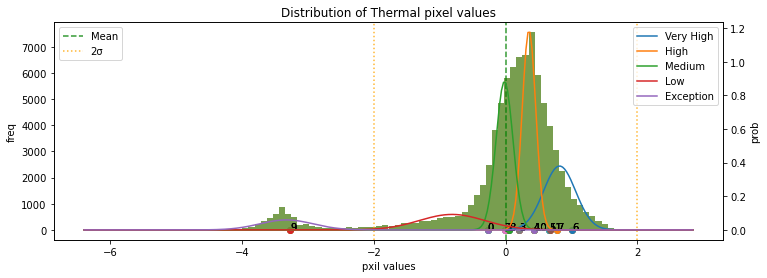

******* end *******
******* start *******
212.jpg
Module type1: Multi-Hotspots
Module type2: Multi-Hotspots


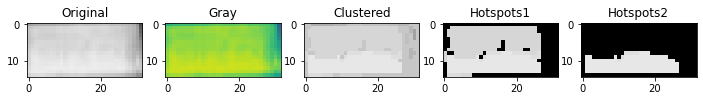

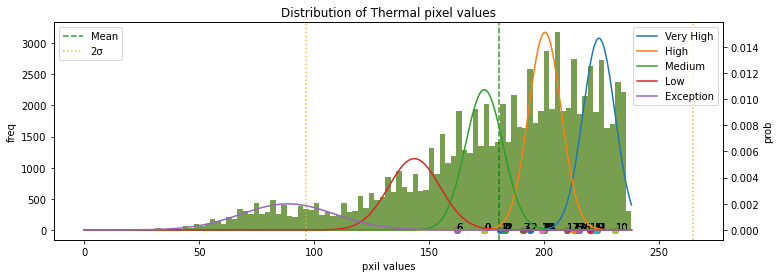

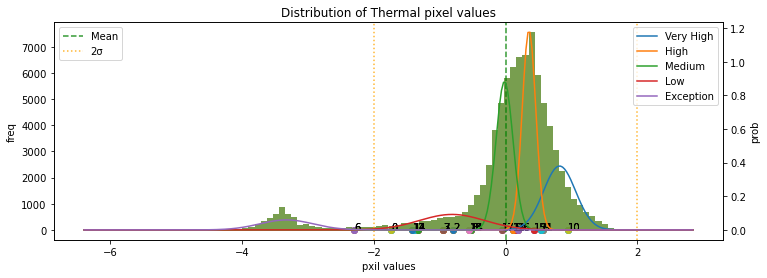

******* end *******
******* start *******
207.jpg
Module type1: Normal
Module type2: Multi-Hotspots


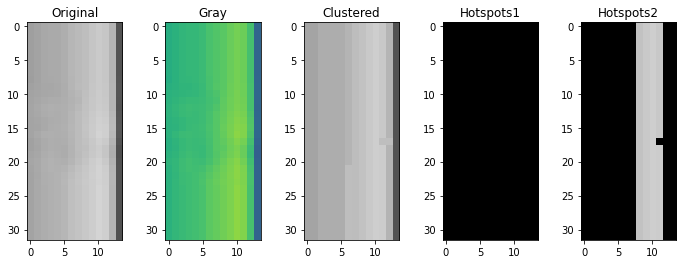

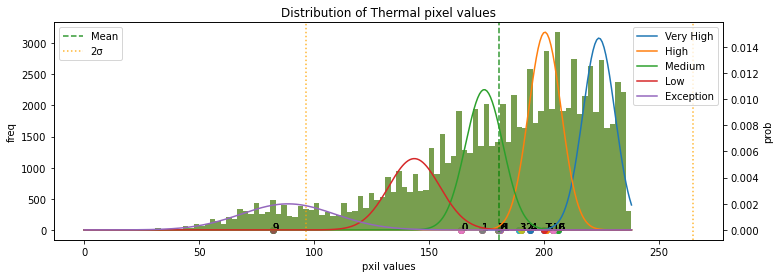

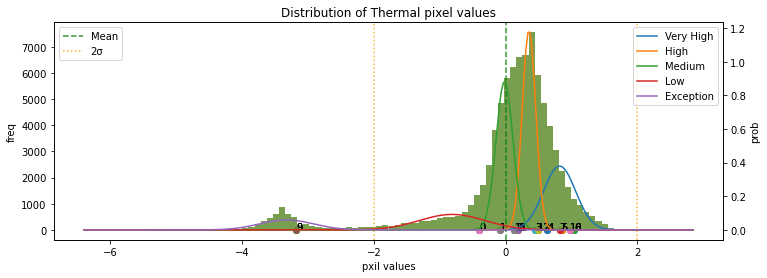

******* end *******
******* start *******
159.jpg
Module type1: Normal
Module type2: Multi-Hotspots


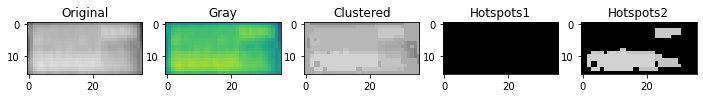

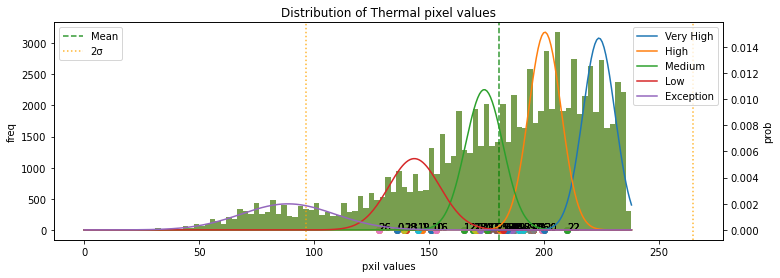

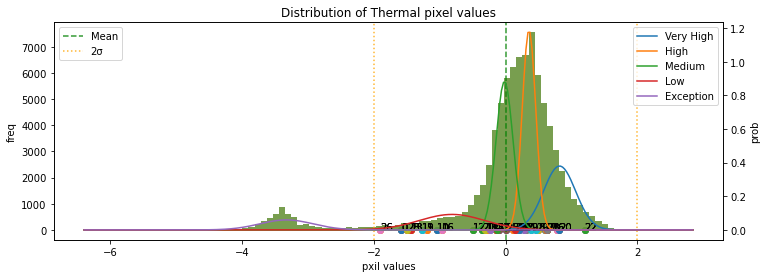

******* end *******
******* start *******
64.jpg
Module type1: Normal
Module type2: Single-Hotspot


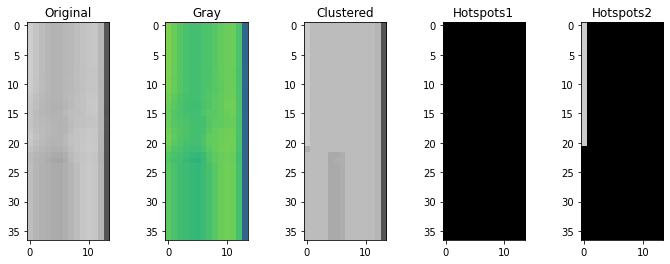

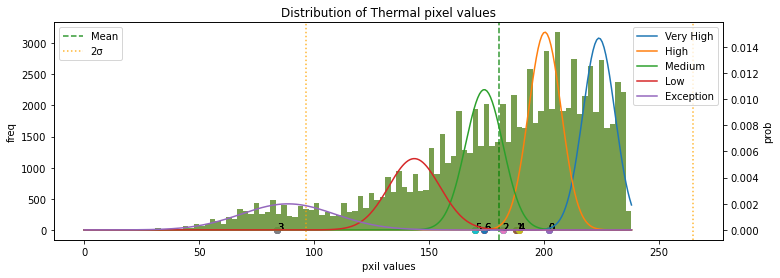

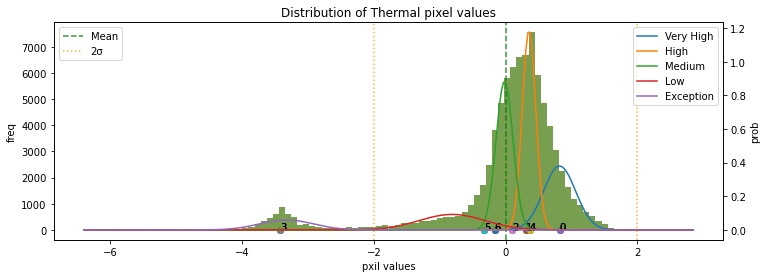

******* end *******
******* start *******
70.jpg
Module type1: Cluster-Anomaly
Module type2: Cluster-Anomaly


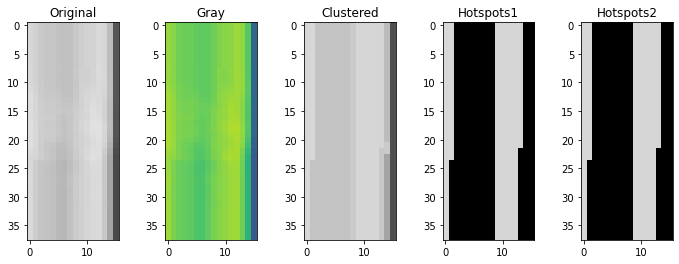

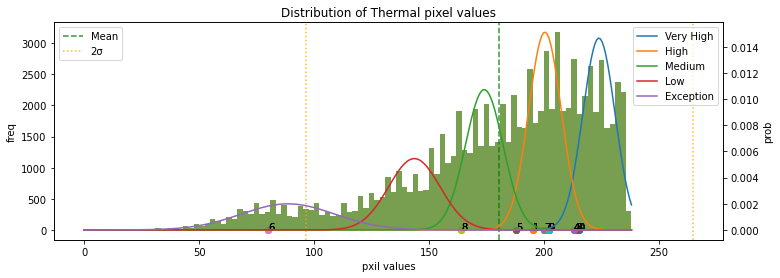

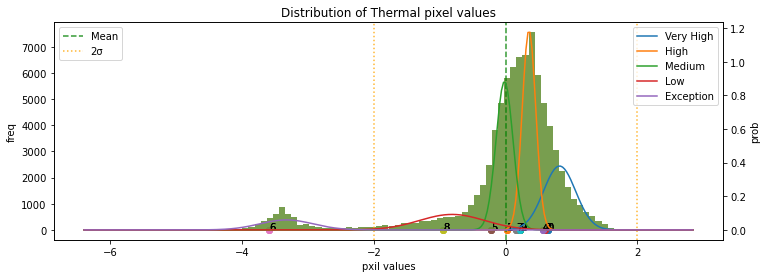

******* end *******
******* start *******
58.jpg
Module type1: Cluster-Anomaly
Module type2: Cluster-Anomaly


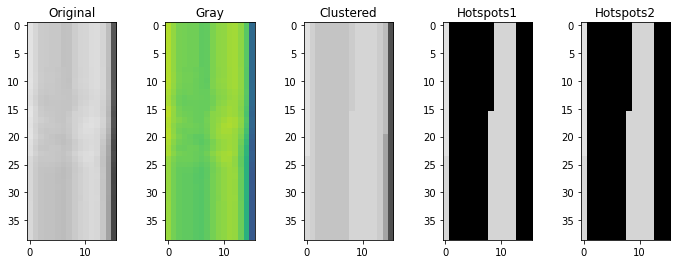

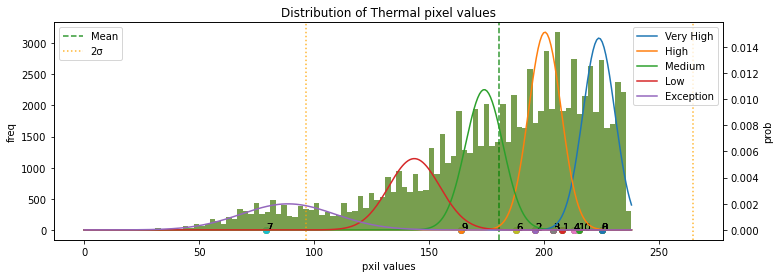

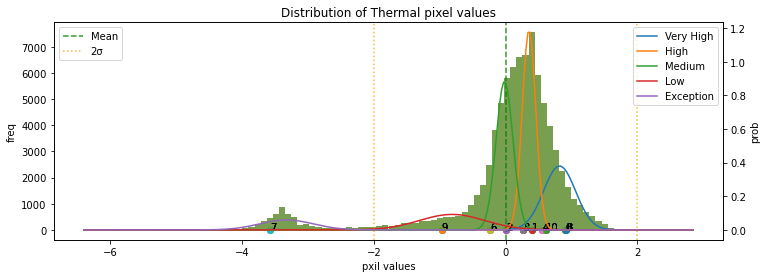

******* end *******
******* start *******
8.jpg
Module type1: Normal
Module type2: Single-Hotspot


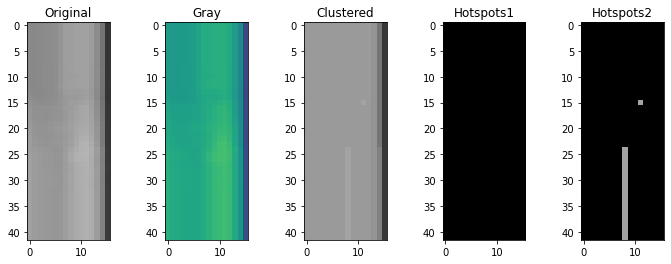

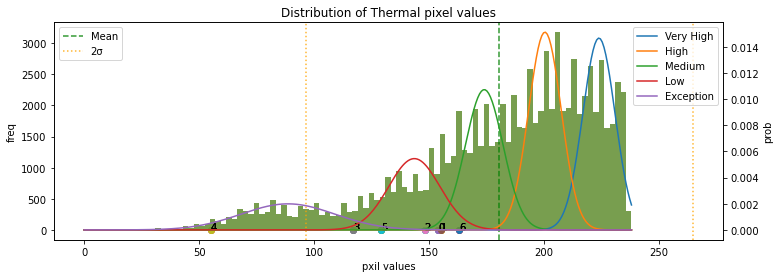

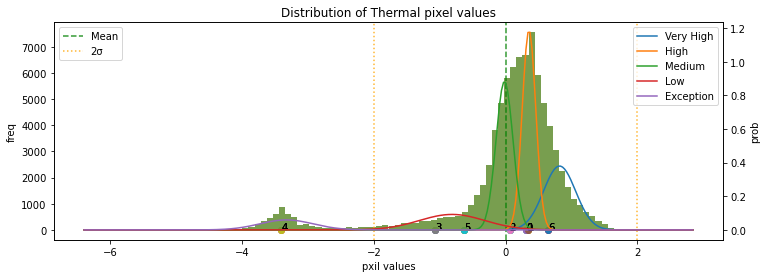

******* end *******
******* start *******
198.jpg
Module type1: Single-Hotspot
Module type2: Single-Hotspot


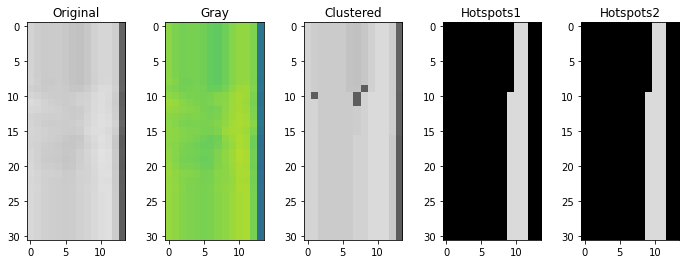

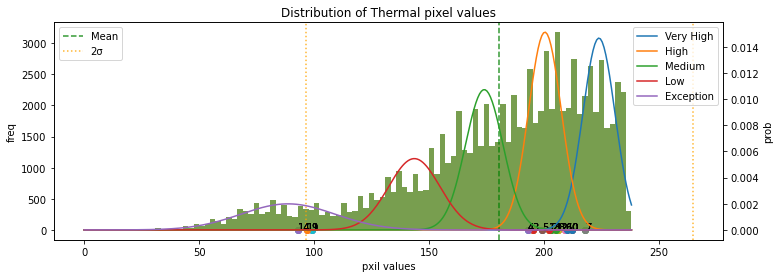

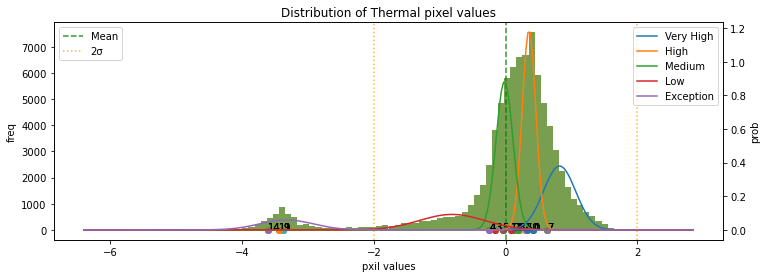

******* end *******
******* start *******
66.jpg
Module type1: Normal
Module type2: Multi-Hotspots


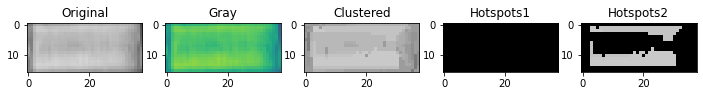

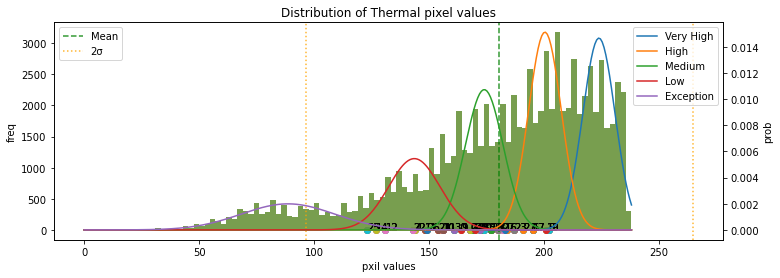

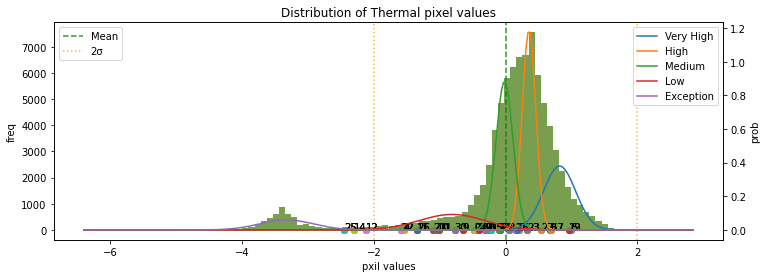

******* end *******
******* start *******
72.jpg
Module type1: Multi-Hotspots
Module type2: Multi-Hotspots


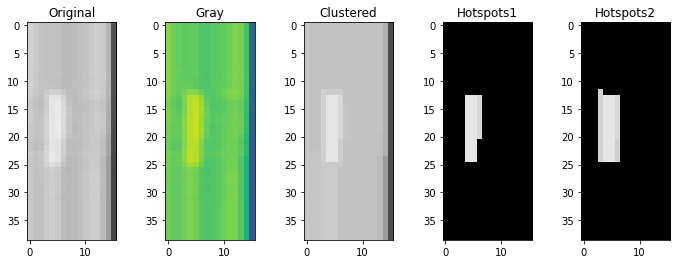

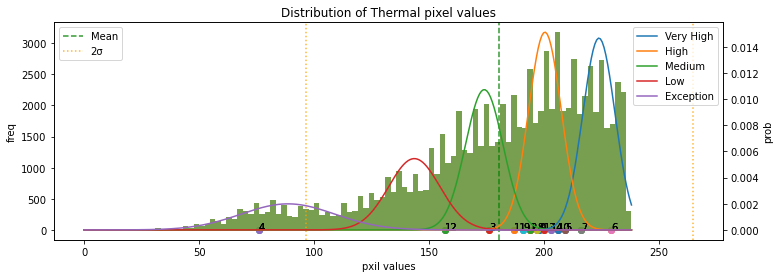

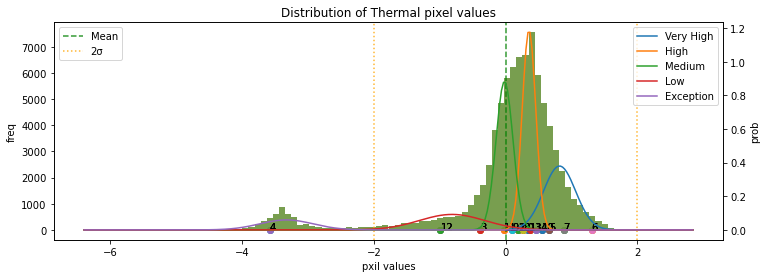

******* end *******
******* start *******
211.jpg
Module type1: Multi-Hotspots
Module type2: Multi-Hotspots


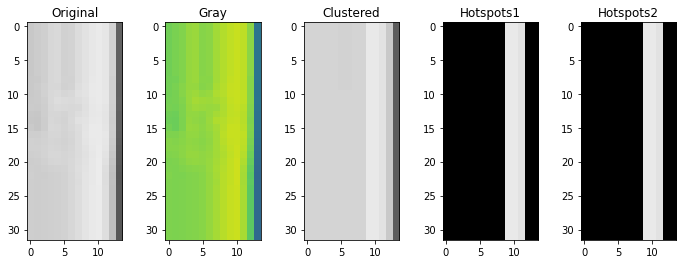

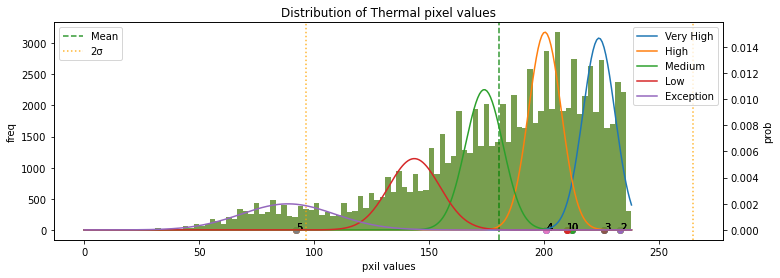

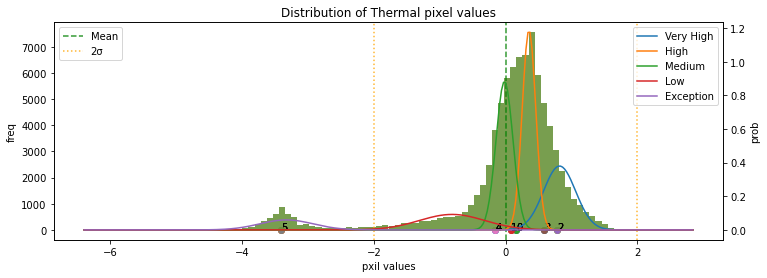

******* end *******
******* start *******
205.jpg
Module type1: Normal
Module type2: Multi-Hotspots


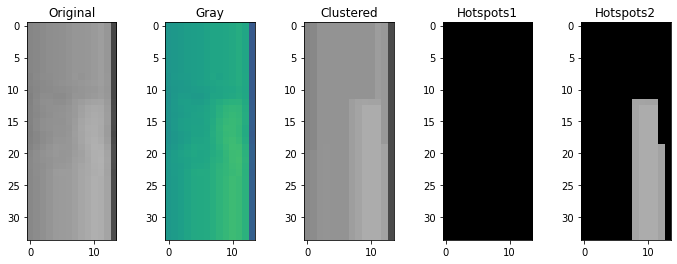

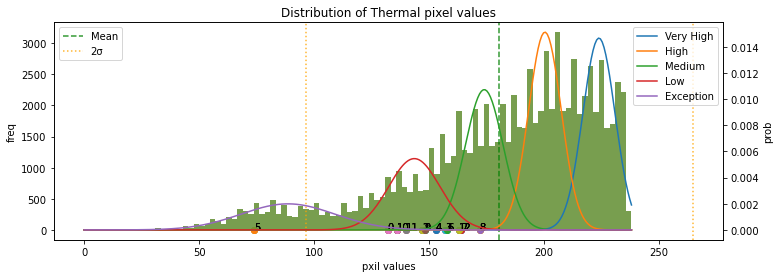

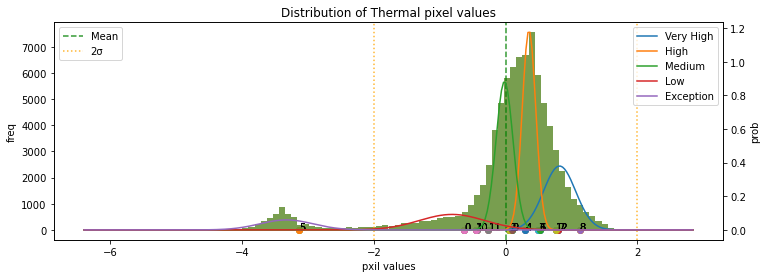

******* end *******
******* start *******
204.jpg
Module type1: Normal
Module type2: Cluster-Anomaly


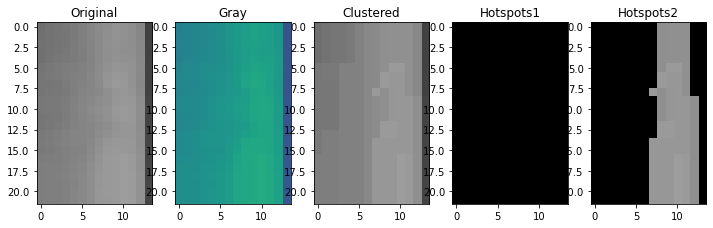

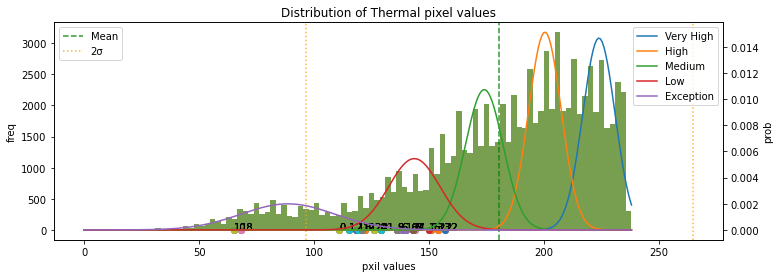

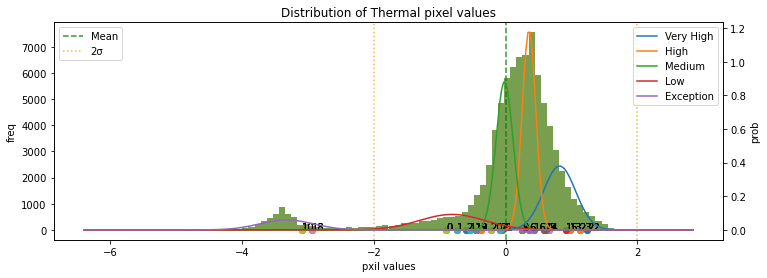

******* end *******
******* start *******
210.jpg
Module type1: Cluster-Anomaly
Module type2: Multi-Hotspots


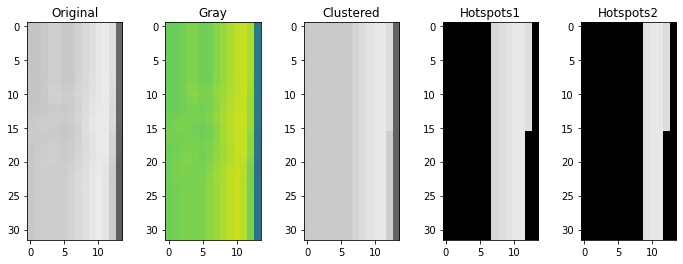

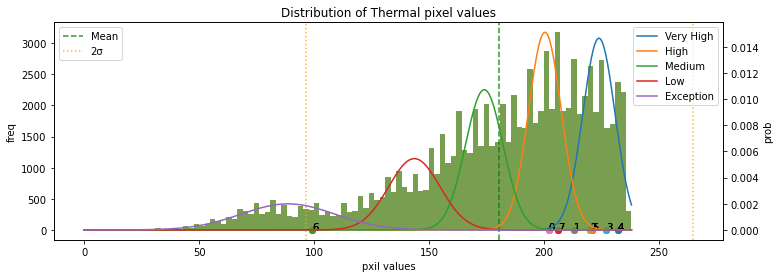

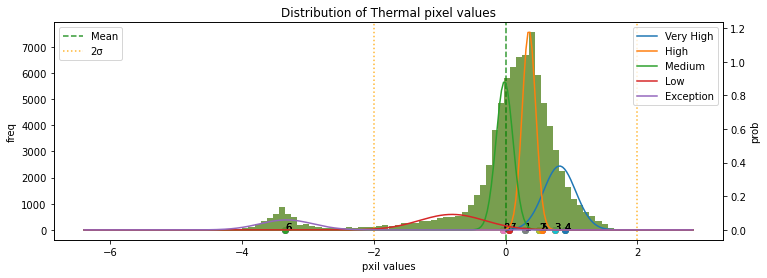

******* end *******
******* start *******
73.jpg
Module type1: Normal
Module type2: Cluster-Anomaly


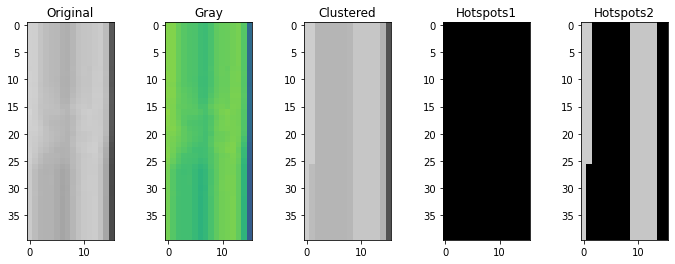

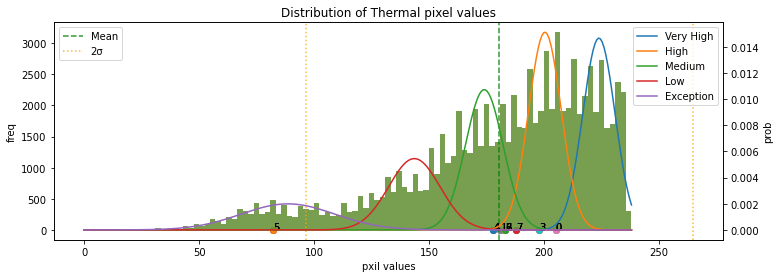

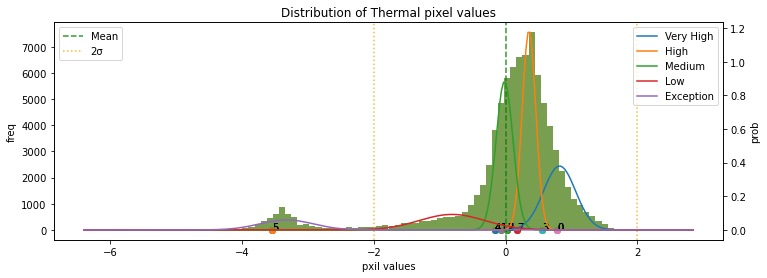

******* end *******
******* start *******
199.jpg
Module type1: Module-Anomaly
Module type2: Normal


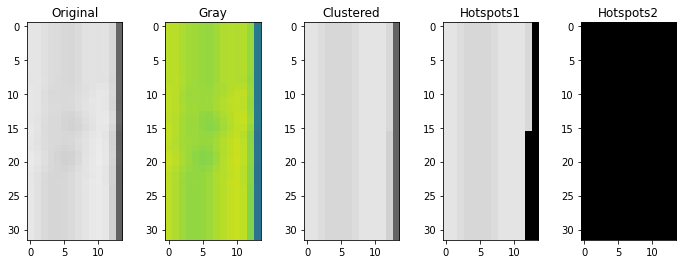

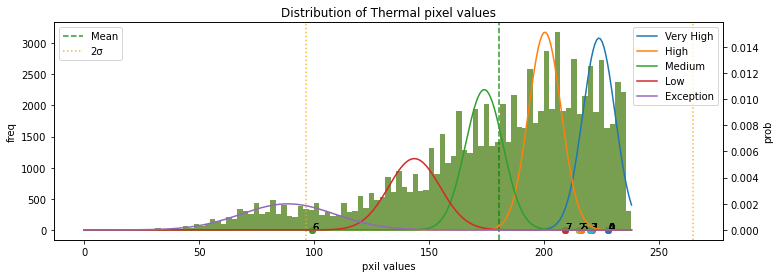

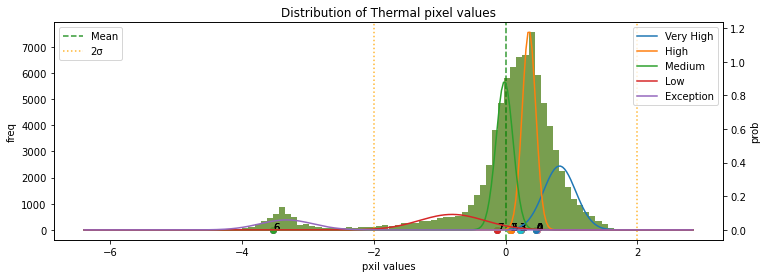

******* end *******
******* start *******
67.jpg
Module type1: Multi-Hotspots
Module type2: Multi-Hotspots


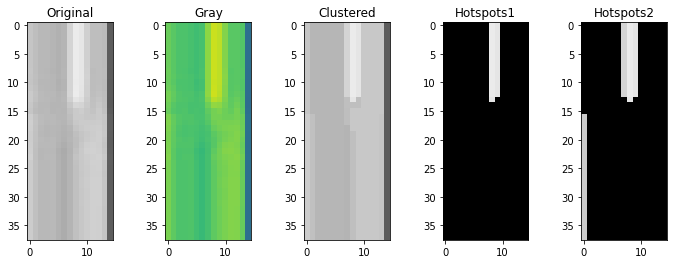

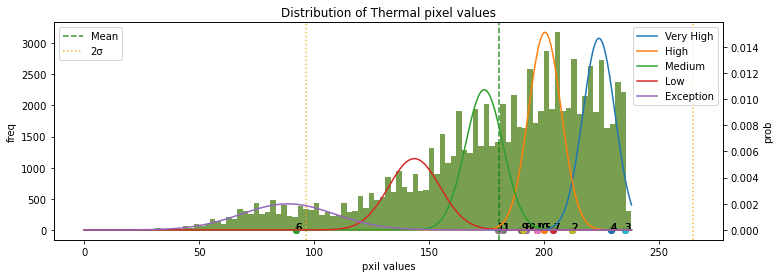

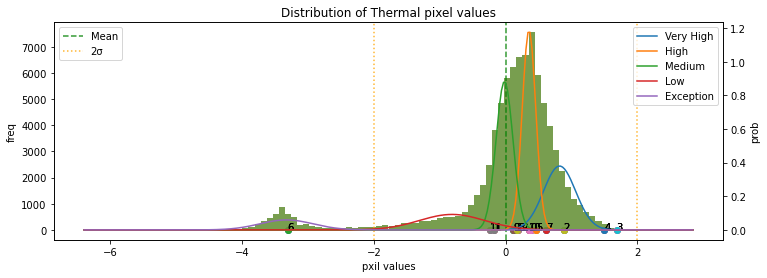

******* end *******
******* start *******
9.jpg
Module type1: Normal
Module type2: Multi-Hotspots


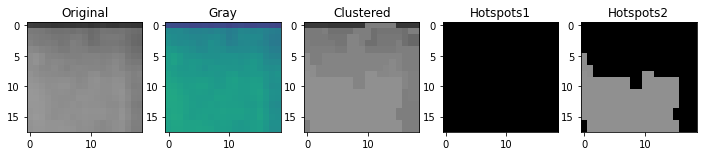

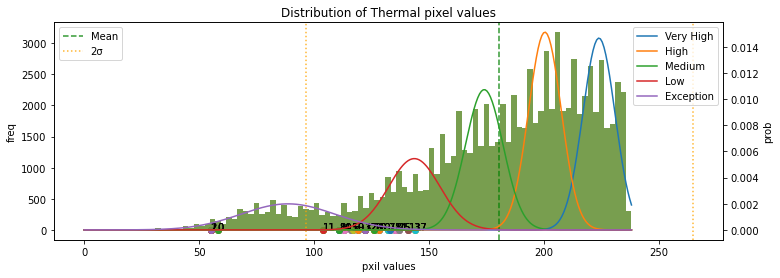

In [ ]:
#for k in list(data.temperature.keys())[1:10]:
for k in list(data.temperature.keys()):    
    print("******* start *******")
    print(k)
    # -- cluster temperature ---
    clusters = clustering.TemperatureClusters(
        data.scaled_temperature_with_index[k], method=clustering_method)    
    clusters_temperature = clusters.get_clusters_data(data.temperature[k])
    centers_temperature = np.stack([np.uint8(t.mean(axis=0)) for t in clusters_temperature])
    scaled_clusters_temperature = clusters.get_clusters_data(data.scaled_temperature[k])
    scaled_centers_temperature = np.stack([t.mean(axis=0) for t in scaled_clusters_temperature ])
    # -- anomaly detection --    
    module_type1, hot_pixels1, cluster_types1 = get_module_anomaly_type(
        centers_temperature, gmm1, thermal_img_files[k])
    module_type2, hot_pixels2, cluster_types2 = get_module_anomaly_type(
        scaled_centers_temperature, gmm2, thermal_img_files[k])
    # -- save anomaly modules --
    if module_type1 not in anomaly_modules:
        anomaly_modules[module_type1] = [k]
    else:
        anomaly_modules[module_type1].append(k)
    print("Module type1:", module_type1)
    print("Module type2:", module_type2)
    # -- display -- 
    img_clustered = centers_temperature[clusters.labels] 
    img_clustered = img_clustered.reshape(thermal_img_files[k].shape)
    img_hotspots1 = img_clustered * hot_pixels1
    img_hotspots2 = img_clustered * hot_pixels2    
    display.display_modules({
        "Original": thermal_img_files[k], 
        "Gray": thermal_img_files_gray[k],
        "Clustered": img_clustered,
        "Hotspots1": img_hotspots1,
        "Hotspots2": img_hotspots2,        
    })
    display.display_distributions(
        data.all_temperature, 
        filepath = "./hist/hist_" + k,
        cluster_centers = centers_temperature,
        gmm = gmm1
    )
    display.display_distributions(
        data.scaled_all_temperature, 
        filepath = "./hist/scaled_hist_" + k,
        cluster_centers = scaled_centers_temperature,
        gmm = gmm2
    )
    print("******* end *******")

In [ ]:
import pandas as pd
for k, v in anomaly_modules.items():
    pd.DataFrame(v,columns=[k]).to_csv("modules_{}.csv".format(k),index=False)

In [ ]:
#ToDo
## 異常部分へのマーキング（赤で囲む）
## 分類モデルの改良